tf.Tensor(-1.99893, shape=(), dtype=float32)


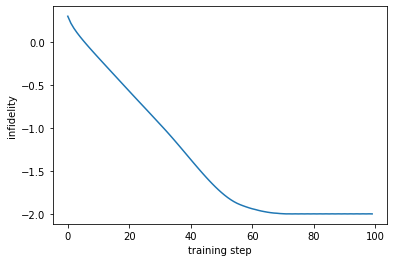

In [11]:
from functools import partial
import numpy as np
import tensorflow as tf
#import jax
#from jax.config import config

#config.update("jax_enable_x64", True)
#from jax import numpy as jnp
#from jax.experimental import optimizers
import tensorcircuit as tc
import math
import matplotlib.pyplot as plt
K = tc.set_backend("tensorflow")
zz = np.kron(tc.gates._z_matrix, tc.gates._z_matrix)

n = 3
l1 = 5
P = K.ones(shape = [l1, 2], dtype = "float32")
seed = K.ones(shape = [l1, n], dtype = "float32")
h = [0 for i in range(l1)]
px = 0.1
py = 0.9
pz = 0.1


def rzz(c,i,j, params):
    c.cnot(i,i+1)
    c.rz(i+1,theta=params[j, 0])
    c.cnot(i,i+1)
    return c

def energy(c: tc.Circuit):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e += h[i] * c.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n - 1):  # OBC
        e += (-1.0) * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [(i + 1) % n])
        )  # <Z_iZ_{i+1}>
    return tc.backend.real(e)
    

def ex(params):
    global seed
    c=tc.Circuit(n)
    k=l1
    for i in range(n):
        c.h(i)
    for j in range(k):
        for i in range(n):
            c.rx(i,theta=params[j, 1])
        for i in range(n-1):
            c = rzz(c,i,j, params)
#        for i in range(n):
#           c.depolarizing(i, px=px, py=py, pz=pz, status=seed[j][i])
    return energy(c)

vge = K.value_and_grad(ex)

params = P
history = [ ]
opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

for _ in range(100):
    v, g = vge(params)
    params = opt.update(g, params)
    history.append(v)

plt.plot([i for i in range(100)], history)
plt.ylabel("infidelity")
plt.xlabel("training step")

print(history[-1])